In [48]:
!pip install torch torchvision
!pip install -U finance-datareader


Requirement already up-to-date: finance-datareader in /usr/local/lib/python3.6/dist-packages (0.9.6)


In [0]:
import FinanceDataReader as fdr
import datetime
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import numpy as np
import argparse
import time
from copy import deepcopy # Add Deepcopy for args
from sklearn.metrics import mean_absolute_error

In [0]:
%matplotlib inline
#데이터 생성과 화면 표시를 위한 라이브러리 호출
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d


In [0]:
class StockDataset(Dataset):
    
    def __init__(self, symbol, x_frames, y_frames, start, end):
        
        self.symbol = symbol
        self.x_frames = x_frames
        self.y_frames = y_frames
        
        self.start = datetime.datetime(*start)
        self.end = datetime.datetime(*end)

        self.data = fdr.DataReader(self.symbol, self.start, self.end)
        print(self.data.isna().sum())
        
    def __len__(self):
        return len(self.data) - (self.x_frames + self.y_frames) + 1
    
    def __getitem__(self, idx):
        idx += self.x_frames
        data = self.data.iloc[idx-self.x_frames:idx+self.y_frames]
        data = data[['High', 'Low', 'Open', 'Close', 'Change', 'Volume']]
        data = data.apply(lambda x: (x+1) / (x[self.x_frames-1]+1))
        data = data.values
        X = data[:self.x_frames]
        y = data[self.x_frames:]
        
        return X, y

In [0]:
class TestDataset(Dataset):
    
    def __init__(self, symbol, x_frames, y_frames):
        
        self.symbol = symbol
        self.x_frames = x_frames
        self.y_frames = y_frames
        
        self.start = datetime.datetime.now() - datetime.timedelta(days=10)
        self.end = datetime.date.today()
        print(self.start)
        print(self.end)
        self.data = fdr.DataReader(self.symbol, self.start, self.end)
        self.data = self.data.tail(6)
        print(self.data)
        print(self.data.isna().sum())
        
    def __len__(self):
        return len(self.data) - (self.x_frames + self.y_frames) + 1
    
    def __getitem__(self, idx):
        idx += self.x_frames
        data = self.data.iloc[idx-self.x_frames:idx+self.y_frames]
        data = data[['High', 'Low', 'Open', 'Close', 'Change', 'Volume']]
        #data = data.apply(lambda x: (x+1) / (x[self.x_frames-1]+1))
        data = data.values
        X = data[:self.x_frames]
        y = data[self.x_frames:]
        
        return X, y

In [0]:
class LSTM(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, batch_size):
        super(LSTM, self).__init__()
        self.input_dim = input_dim 
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.num_layers = num_layers

        self.batch_size = batch_size
        
        self.lstm = nn.LSTM(self.input_dim, self.hidden_dim, self.num_layers)
        self.hidden = self.init_hidden()
        self.regressor = self.make_regressor()
        
    def init_hidden(self):
        return (torch.zeros(self.num_layers, self.batch_size, self.hidden_dim),
                torch.zeros(self.num_layers, self.batch_size, self.hidden_dim))
    
    def make_regressor(self):
        layers = []
        
        layers.append(nn.Linear(self.hidden_dim, self.hidden_dim // 2))
        layers.append(nn.ReLU())
        layers.append(nn.Linear(self.hidden_dim // 2, self.output_dim))
        regressor = nn.Sequential(*layers)
        return regressor
    
    def forward(self, x):
        lstm_out, self.hidden = self.lstm(x, self.hidden)
        y_pred = self.regressor(lstm_out[-1].view(self.batch_size, -1))
        return y_pred

In [0]:
def metric(y_pred, y_true):
    perc_y_pred = np.exp(y_pred.cpu().detach().numpy())
    perc_y_true = np.exp(y_true.cpu().detach().numpy())
    mae = mean_absolute_error(perc_y_true, perc_y_pred, multioutput='raw_values')
    return mae*100

In [0]:

#trainloader = torch.cat(trainloader).view(len(trainloader), batch_size, -1)
def train(model, trainStock, optimizer, loss_fn,batch_size,device):
    trainloader = DataLoader(trainStock, batch_size, shuffle=True, drop_last=True)

    model.train()
    model.zero_grad()
    optimizer.zero_grad()

    train_acc = 0.0
    train_loss = 0.0
    for i, (X, y) in enumerate(trainloader):

        X = X.transpose(0, 1).float().to(device)
        y_true = y[:, :, 3].float().to(device)

        model.zero_grad()
        optimizer.zero_grad()
        model.hidden = [hidden.to(device) for hidden in model.init_hidden()]

        y_pred = model(X)
        loss = loss_fn(y_pred.view(-1), y_true.view(-1))
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_acc += metric(y_pred, y_true)[0]

    train_loss = train_loss / len(trainloader)
    train_acc = train_acc / len(trainloader)
    return model, train_loss, train_acc

In [0]:
def validate(model, valStock, loss_fn,batch_size,device):
    valloader = DataLoader(valStock, batch_size, shuffle=False, drop_last=True)
    model.eval()

    val_acc = 0.0
    val_loss = 0.0
    with torch.no_grad():
        for i, (X, y) in enumerate(valloader):

            X = X.transpose(0, 1).float().to(device)
            y_true = y[:, :, 3].float().to(device)
            model.hidden = [hidden.to(device) for hidden in model.init_hidden()]

            y_pred = model(X)
            loss = loss_fn(y_pred.view(-1), y_true.view(-1))

            val_loss += loss.item()
            val_acc += metric(y_pred, y_true)[0]

    val_loss = val_loss / len(valloader)
    val_acc = val_acc / len(valloader)
    return val_loss, val_acc


In [0]:
def test(model, testStock, loss_fn,batch_size,device):
    testloader = DataLoader(testStock, batch_size, shuffle=False, drop_last=True)
    model.eval()

    test_acc = 0.0
    test_result = []
    with torch.no_grad():
        for i, (X, y) in enumerate(testloader):

            X = X.transpose(0, 1).float().to(device)
            y_true = y[:, :, 3].float().to(device)
            model.hidden = [hidden.to(device) for hidden in model.init_hidden()]

            y_pred = model(X)
            test_result.append([y_pred,y_true])
            test_acc += metric(y_pred, y_true)[0]

    test_acc = test_acc / len(testloader)
    return test_acc, test_result

In [58]:
stock = StockDataset('001040',3,3,(2010,5,1),(2016,5,20))
valstock = StockDataset('001040',3,3,(2017,5,1),(2018,5,20))
teststock = StockDataset('001040',3,3,(2019,5,1),(2020,5,20))

Open      0
High      0
Low       0
Close     0
Volume    0
Change    0
dtype: int64
Open      0
High      0
Low       0
Close     0
Volume    0
Change    0
dtype: int64
Open      0
High      0
Low       0
Close     0
Volume    0
Change    0
dtype: int64


In [59]:
batch_size = 1
input_dim = 6
hidden_dim = 50
output_dim = 3
num_layers = 1
epoch = 5

model = LSTM(input_dim,hidden_dim,output_dim,num_layers,batch_size)
loss_fn = torch.nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

'''
for i in range(5):
    model, tl = train(model,stock,optimizer,loss_fn,batch_size,device)
    vl = validate(model,valstock,loss_fn,batch_size,device)
    print(tl,vl)
ta = test(model,teststock,loss_fn,batch_size,device)
print(tl,vl,ta)
'''

'\nfor i in range(5):\n    model, tl = train(model,stock,optimizer,loss_fn,batch_size,device)\n    vl = validate(model,valstock,loss_fn,batch_size,device)\n    print(tl,vl)\nta = test(model,teststock,loss_fn,batch_size,device)\nprint(tl,vl,ta)\n'

In [60]:
#학습
for e in range(epoch):  # loop over the dataset multiple times
        ts = time.time()
        model, train_loss, train_acc = train(model, stock ,optimizer, loss_fn, batch_size,device)
        val_loss, val_acc = validate(model, valstock, loss_fn, batch_size,device)
        te = time.time()
        
        print('Epoch {}, Acc(train/val): {:2.2f}/{:2.2f}, Loss(train/val) {:2.5f}/{:2.5f}. Took {:2.2f} sec'.format(e, train_acc, val_acc, train_loss, val_loss, te-ts))
        
test_acc,test_result = test(model, teststock, loss_fn, batch_size, device ) 

Epoch 0, Acc(train/val): 9.91/5.54, Loss(train/val) 0.00499/0.00173. Took 19.69 sec
Epoch 1, Acc(train/val): 8.51/15.20, Loss(train/val) 0.00202/0.00241. Took 19.64 sec
Epoch 2, Acc(train/val): 7.08/5.24, Loss(train/val) 0.00162/0.00066. Took 19.73 sec
Epoch 3, Acc(train/val): 6.55/4.55, Loss(train/val) 0.00145/0.00066. Took 19.47 sec
Epoch 4, Acc(train/val): 5.74/3.53, Loss(train/val) 0.00132/0.00093. Took 19.80 sec


In [61]:
print(test_acc)

4.5353594802496


In [78]:
testset = TestDataset('005930',3,3)

2020-05-26 14:15:43.556553
2020-06-05
             Open   High    Low  Close    Volume    Change
Date                                                      
2020-05-29  50000  50700  49700  50700  27596961  0.005952
2020-06-01  50800  51200  50600  51200  16949183  0.009862
2020-06-02  51000  51500  50800  51400  14247933  0.003906
2020-06-03  51800  55000  51700  54500  49257814  0.060311
2020-06-04  55800  57000  54600  54600  40220334  0.001835
2020-06-05  54400  55900  54000  55500  22399065  0.016484
Open      0
High      0
Low       0
Close     0
Volume    0
Change    0
dtype: int64


In [0]:
model.eval()
plr = DataLoader(testset,batch_size,shuffle=True)


In [80]:

for (X,y) in plr:
    X = X.transpose(0, 1).float().to(device)
    y_true = y[:, :, 3].float().to(device)
    model.hidden = [hidden.to(device) for hidden in model.init_hidden()]
    y_pred = model(X)
    
    print(y_pred,y_true)
    
print(y_pred[0][2]*y_true[0][2])

tensor([[0.9758, 1.0270, 0.9759]], device='cuda:0', grad_fn=<AddmmBackward>) tensor([[54500., 54600., 55500.]], device='cuda:0')
tensor(54162.2812, device='cuda:0', grad_fn=<MulBackward0>)


In [65]:
'''from google.colab import drive
drive.mount('/content/gdrive')
modelPath = '/content/gdrive/My Drive/LSTM_batch_1_model.pt'
torch.save(model.state_dict(), modelPath)'''

"from google.colab import drive\ndrive.mount('/content/gdrive')\nmodelPath = '/content/gdrive/My Drive/LSTM_batch_1_model.pt'\ntorch.save(model.state_dict(), modelPath)"

[[tensor([[1.0016, 1.0206, 1.0250]], device='cuda:0'), tensor([[0.9915, 0.9617, 0.9489]], device='cuda:0')], [tensor([[1.0016, 1.0206, 1.0250]], device='cuda:0'), tensor([[0.9700, 0.9571, 0.9313]], device='cuda:0')], [tensor([[1.0017, 1.0207, 1.0250]], device='cuda:0'), tensor([[0.9867, 0.9602, 0.9425]], device='cuda:0')], [tensor([[1.0017, 1.0207, 1.0250]], device='cuda:0'), tensor([[0.9731, 0.9552, 0.9596]], device='cuda:0')], [tensor([[1.0016, 1.0206, 1.0250]], device='cuda:0'), tensor([[0.9816, 0.9862, 0.9677]], device='cuda:0')], [tensor([[1.0016, 1.0207, 1.0250]], device='cuda:0'), tensor([[1.0047, 0.9859, 0.9718]], device='cuda:0')], [tensor([[1.0016, 1.0206, 1.0250]], device='cuda:0'), tensor([[0.9813, 0.9673, 0.9673]], device='cuda:0')], [tensor([[1.0016, 1.0206, 1.0250]], device='cuda:0'), tensor([[0.9857, 0.9857, 0.9905]], device='cuda:0')], [tensor([[1.0016, 1.0206, 1.0250]], device='cuda:0'), tensor([[1.0000, 1.0048, 0.9758]], device='cuda:0')], [tensor([[1.0016, 1.0206, 1

Text(0.5, 1.0, 'pred vs real')

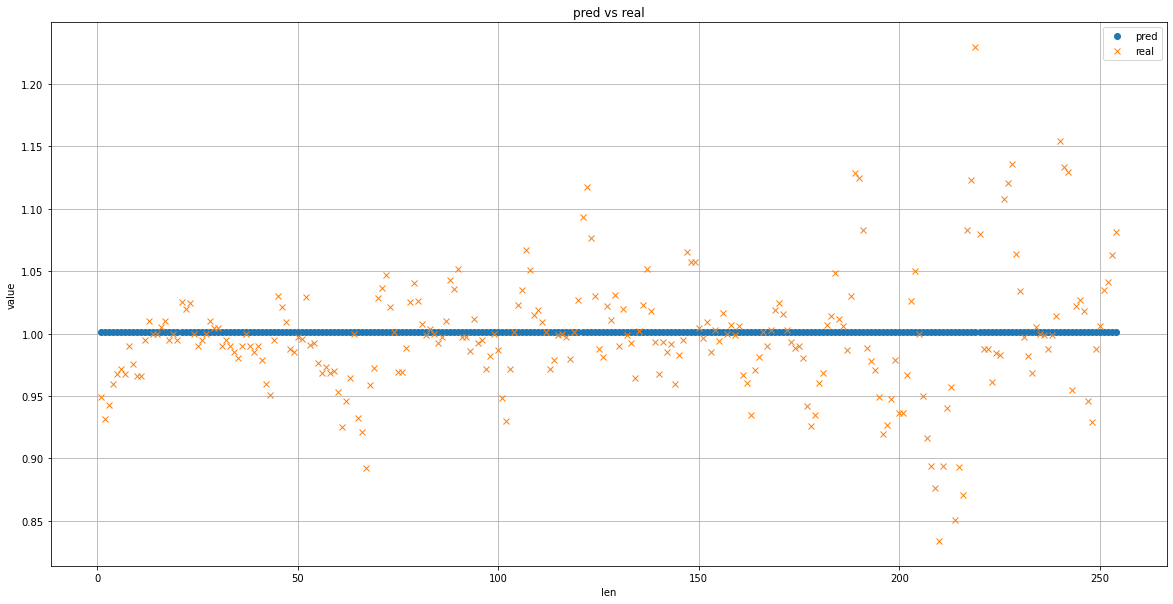

In [70]:
fig = plt.figure(figsize=(20,10))
xl = [n for n in range(1,len(test_result)+1)]

print(test_result)
pred = []
real = []
for i in test_result:
    pred.append(i[0][0][0])
    real.append(i[1][0][2])

print(pred)
print(real)

# ====== test plot ====== #
ax = fig.add_subplot(1, 1, 1)
ax.plot(xl, pred, 'o', label='pred')
ax.plot(xl, real, 'x', label='real')
ax.set_xlabel('len')
ax.set_ylabel('value')
ax.grid()
ax.legend()
ax.set_title('pred vs real')